### Notebook to visualize FreeSurfer measaures on surfaces and parcellations

In [1]:
from brainspace.datasets import load_group_fc, load_parcellation, load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.mesh.mesh_io import read_surface
from nibabel.freesurfer.mghformat import load
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn import datasets, surface, plotting
import seaborn as sns

In [2]:
### Load data
current_release = "Aug_2024"
FS_version = "7.3.2" #"6.0.1" #"7.3.2"
session = "ses-01"
dataset = "qpn"


dataset_dir = f"/home/nikhil/projects/Parkinsons/{dataset}/"
release_dir = f"{dataset_dir}/releases/{current_release}/"
tabular_dir = f"{release_dir}/tabular/"

# Current nipoppy manifest
manifest_csv = f"{release_dir}/manifest.csv"

# demographics
demographics_csv = f"{tabular_dir}/demographics.csv"

# Dx
dx_csv = f"{tabular_dir}/assessments/diagnosis.csv"

# imaging derivatives
FS_dir = f"{dataset_dir}/derivatives/freesurfer/v{FS_version}"

# ROI stats

DKT_csv = "/home/nikhil/projects/Parkinsons/neuro_arch/analysis/IDP/qpn/Aug_2024/agg_dfs/CT_DKT_df.csv"


# Surface maps
FS_surf_dir = f"{FS_dir}/surfmaps/{session}/"

### Surface and annotation files

- Possible surfaces: ["fsaverage", "fsaverage5"]
- Possible annot: 
    - "fsaverage": ["aparc", "aparc.a2009s", "Yeo2011_7Networks_N1000", "Yeo2011_17Networks_N1000"]
    - "fsaverage5": ["schaefer-500"]

In [3]:
template_surface = "fsaverage" # "fsaverage" or "fsaverage5"
annot = "aparc" #"Yeo2011_7Networks_N1000"

if template_surface == "fsaverage":
    fsaverage_dir = "/home/nikhil/projects/Parkinsons/qpn/derivatives/freesurfer/v6.0.1/output/ses-01/fsaverage/"
    annot_dir = f"{fsaverage_dir}/label/"
    
else:
    fsaverage_dir = "/home/nikhil/projects/neuroinformatics_tools/micapipe/surfaces/fsaverage5/"
    annot_dir = "/home/nikhil/projects/neuroinformatics_tools/micapipe/parcellations/"

surf_dir = f"{fsaverage_dir}/surf/"

pial_lh = read_surface(f"{surf_dir}/lh.pial", itype='fs')
pial_rh = read_surface(f"{surf_dir}/rh.pial", itype='fs')


if annot in ["aparc", "aparc.a2009s", "Yeo2011_7Networks_N1000", "Yeo2011_17Networks_N1000"]:
    annot_lh= f"{annot_dir}/lh.{annot}.annot"
    annot_rh= f"{annot_dir}/rh.{annot}.annot"
else:
    annot_lh= f"{annot_dir}/lh.{annot}_mics.annot"
    annot_rh= f"{annot_dir}/rh.{annot}_mics.annot"

labels = np.concatenate((nib.freesurfer.read_annot(annot_lh)[0], nib.freesurfer.read_annot(annot_rh)[0]), axis=0)

print(f"tempate surface: {template_surface}, annot: {annot}")
print(f"shape of concat array: {labels.shape}")

tempate surface: fsaverage, annot: aparc
shape of concat array: (327684,)


In [41]:
unique_labels = set(nib.freesurfer.read_annot(annot_rh)[0])
print(f"Number of unique labels: {len(unique_labels)}")
ROIs = nib.freesurfer.read_annot(annot_rh)[2]
ROIs = [r.decode("utf-8") for r in ROIs] 
n_ROIs = len(ROIs)
print(f"Number of ROIs: {n_ROIs}")
ROIs_df = pd.DataFrame(ROIs, columns=["ROI"])
ROIs_df["ROI_index"] = np.arange(n_ROIs)
ROIs_df.tail()

Number of unique labels: 35
Number of ROIs: 36


ROI  ROI_index
31       supramarginal         31
32         frontalpole         32
33        temporalpole         33
34  transversetemporal         34
35              insula         35

plotting parcellation


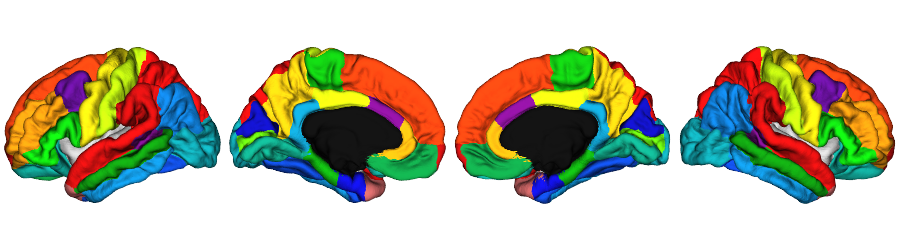

In [42]:
# plot labels on surface
print("plotting parcellation")
plot_hemispheres(pial_lh, pial_rh, array_name=labels, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap='nipy_spectral', transparent_bg=True)

### Plot DKT values on brain

In [7]:
def get_mean_CT_labels_df(ct_df, group, hemi, annot_file, ct_cols):
    """
    Get mean CT values for each ROI per hemi per group
    """
    ct_labels_df = pd.DataFrame()

    mean_ct = ct_df[(ct_df["enrollment_group"]==group) & (ct_dkt_df["hemi"]==hemi)][ct_cols].mean(axis=0)    
    mean_ct_df = pd.DataFrame(mean_ct, columns=["mean_CT"]).reset_index().rename(columns={"index": "ROI"})
    
    # grab ROIs
    fs_annot = nib.freesurfer.read_annot(annot_file)
    ROIs = fs_annot[2]
    ROIs = [r.decode("utf-8") for r in ROIs] 
    n_ROIs = len(ROIs)
    print(f"Number of ROIs: {n_ROIs}")
    ROIs_df = pd.DataFrame(ROIs, columns=["ROI"])
    ROIs_df["ROI_index"] = np.arange(n_ROIs)

    # merge CT values with ROI names and index
    mean_ct_df = mean_ct_df.merge(ROIs_df, on="ROI")

    # ROI_index --> CT_val dict
    ROI_index_CT_dict = mean_ct_df.set_index("ROI_index")["mean_CT"].to_dict()

    # grab vertex wise labels
    labels = fs_annot[0]
    labels_df = pd.DataFrame(labels, columns=["ROI_index"])
    
    CT_df = pd.DataFrame(labels, columns=["ROI_index"])
    CT_df["mean_CT"] = CT_df["ROI_index"].map(ROI_index_CT_dict)

    return CT_df, mean_ct_df, ROI_index_CT_dict

In [15]:
ct_dkt_df

caudalanteriorcingulate  caudalmiddlefrontal  cuneus  entorhinal  \
0                      2.495                2.365   1.781       3.372   
1                      2.299                2.486   1.800       2.979   
2                      2.597                2.626   1.892       3.349   
3                      2.335                2.236   1.506       3.084   
4                      2.418                2.654   1.875       3.616   
..                       ...                  ...     ...         ...   
583                    2.117                2.516   1.963       3.386   
584                    2.537                2.381   1.779       3.428   
585                    2.220                2.268   1.870       3.432   
586                    2.274                2.310   1.819       3.967   
587                    2.477                2.478   1.900       3.577   

     fusiform  inferiorparietal  inferiortemporal  insula  isthmuscingulate  \
0       2.821             2.232             2.785   3.230             2.061   
1       2.575             2.347             2.648   2.612             2.100   
2       2.956             2.457             2.774   3.116             2.364   
3       2.560             2.050             2.578   2.898             2.004   
4       2.765             2.504             2.734   3.343             2.185   
..        ...               ...               ...     ...               ...   
583     2.795             2.437             2.834   3.037             2.530   
584     2.760             2.379             3.040   2.943             2.451   
585     2.901             2.285             2.709   2.875             2.355   
586     2.681             2.426             2.829   3.056             2.074   
587     2.861             2.442             2.767   3.147             2.219   

     lateraloccipital  ...  rostralmiddlefrontal  superiorfrontal  \
0               1.949  ...                 2.217            2.465   
1               2.075  ...                 2.181            2.533   
2               2.008  ...                 2.462            2.726   
3               2.000  ...                 2.184            2.344   
4               2.291  ...                 2.359            2.672   
..                ...  ...                   ...              ...   
583             2.236  ...                 2.305            2.533   
584             2.066  ...                 2.195            2.437   
585             2.136  ...                 2.110            2.476   
586             2.286  ...                 2.269            2.423   
587             2.119  ...                 2.412            2.601   

     superiorparietal  superiortemporal  supramarginal  transversetemporal  \
0               1.987             2.747          2.245               2.042   
1               2.464             2.466          2.275               2.057   
2               2.275             3.036          2.474               2.311   
3               1.917             2.355          2.089               1.903   
4               2.356             2.806          2.534               2.068   
..                ...               ...            ...                 ...   
583             2.164             2.736          2.619               2.388   
584             2.092             2.838          2.400               2.488   
585             1.928             2.714          2.434               2.099   
586             2.161             2.845          2.485               2.362   
587             2.190             2.875          2.603               2.601   

     participant_id             sex  enrollment_group  hemi  
0           MNI0028   Male/Masculin                PD    lh  
1           MNI0056   Male/Masculin                PD    lh  
2           MNI0058   Male/Masculin                PD    lh  
3           MNI0068   Male/Masculin                PD    lh  
4           MNI0079  Female/Féminin                PD    lh  
..              ...             ...      

In [16]:
ct_dkt_df = pd.read_csv(DKT_csv)

demo_cols = ["participant_id", "sex", "enrollment_group", "hemi"]
ct_cols = list(set(ct_dkt_df.columns) - set(demo_cols))

group = "control"

lh_CT_df, _, _ = get_mean_CT_labels_df(ct_dkt_df, group, "lh", annot_lh, ct_cols)
rh_CT_df, _, _ = get_mean_CT_labels_df(ct_dkt_df, group, "rh", annot_rh, ct_cols)

CT_df = pd.concat([lh_CT_df, rh_CT_df], axis=0)
CT_df.head()

Number of ROIs: 36
Number of ROIs: 36


ROI_index   mean_CT
0         24  2.511603
1         29  2.140794
2         28  2.557662
3         27  2.379441
4         24  2.511603

plotting CT values


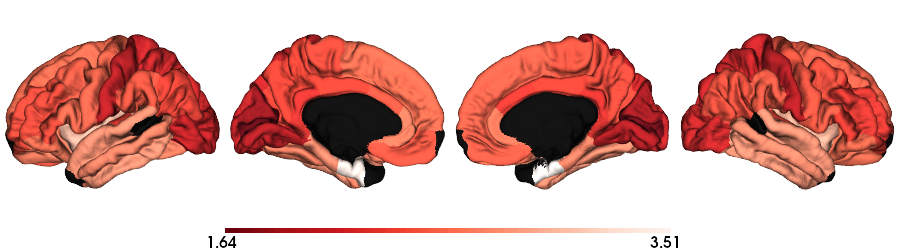

In [23]:
# plot labels on surface
print("plotting CT values")
plot_array = CT_df["mean_CT"].values
plot_hemispheres(pial_lh, pial_rh, array_name=plot_array, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap='Reds_r', transparent_bg=True, color_bar='bottom', layout_style="compact",)

### Plot CT on surface

In [84]:
DX_groups = ["CTRL","PD"] 
hemi_list = ["lh", "rh"]
fwhm = 10

surf_dict = {}
for grp in DX_groups:
    hemi_CT_list = []
    for j, hemi in enumerate(hemi_list):
        CT_img = nib.load(f"{FS_surf_dir}{hemi}_surf_concat_{grp}_{fwhm}mm.mgh")
        avg_CT = np.squeeze(np.mean(CT_img.get_fdata(),axis=3))
        hemi_CT_list.append(np.expand_dims(avg_CT,1))
    
    surf_dict[grp] = np.squeeze(np.concatenate(hemi_CT_list, axis=0))


### Controls

In [21]:
# Plot the surfaces
CTRL_surf = surf_dict["CTRL"]
plot_hemispheres( pial_lh, pial_rh, array_name=CTRL_surf, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, 
                 interactive=True, share='both',layout_style="compact",
                 nan_color=(255, 255, 255, 1), color_range=(1.5, 4), cmap="inferno", transparent_bg=True)


NameError: name 'surf_dict' is not defined

### Parkinsons

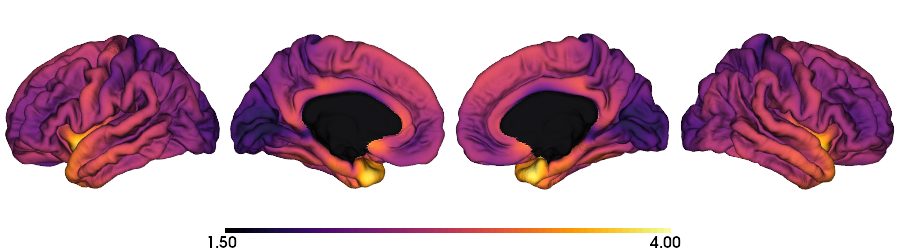

In [86]:
PD_surf = surf_dict["PD"]
plot_hemispheres( pial_lh, pial_rh, array_name=PD_surf, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, 
                 interactive=True, share='both',layout_style="compact",
                 nan_color=(0, 0, 0, 1), color_range=(1.5, 4), cmap="inferno", transparent_bg=True)

### Difference between CTRL and PD

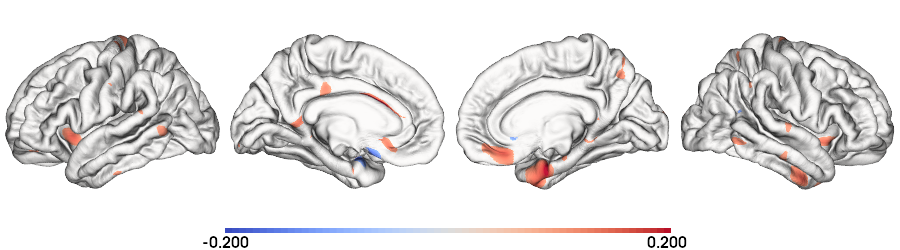

In [87]:
plot_thresh = 0.1
diff_surf = surf_dict["CTRL"] - surf_dict["PD"]
diff_surf[(diff_surf < plot_thresh) & (diff_surf > -plot_thresh)] = 0

plot_hemispheres( pial_lh, pial_rh, array_name=diff_surf, size=(900, 250), color_bar='bottom', zoom=1.25, embed_nb=True, 
                 interactive=True, share='both',layout_style="compact",
                 nan_color=(0, 0, 0, 1), color_range=(-0.2, 0.2), cmap="coolwarm", transparent_bg=True)

### Plot labels on the surface

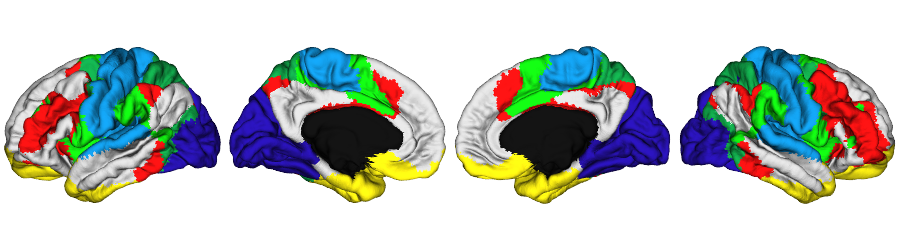

In [88]:
# plot labels on surface
plot_hemispheres(pial_lh, pial_rh, array_name=labels, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap='nipy_spectral', transparent_bg=True)

### Plot average CT per parcel

In [9]:
def get_mean_CT_per_parcel(labels, CT_vals, round_decimals=1):

    CT_parcel_df = pd.DataFrame()
    CT_parcel_df["CT"] = CT_vals
    CT_parcel_df["label"] = labels
    mean_CT_per_label_df = CT_parcel_df.groupby("label").mean().reset_index()
    label_CT_map_dict = dict(zip(mean_CT_per_label_df["label"], mean_CT_per_label_df["CT"]))
    CT_parcel_df["CT_parcel"] = CT_parcel_df["label"].replace(label_CT_map_dict)
    mean_CT_parcel = np.array(CT_parcel_df["CT_parcel"],dtype=np.float32).round(round_decimals)

    return mean_CT_parcel

### Controls

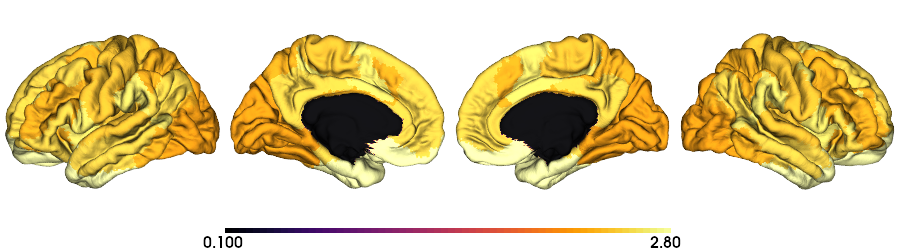

In [90]:
# plot mean CT per parcel on surface
plot_array = get_mean_CT_per_parcel(labels, CTRL_surf)
cmap = "inferno"
plot_hemispheres(pial_lh, pial_rh, array_name=plot_array, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap=cmap, transparent_bg=True,color_bar='bottom') #color_range=(1.5, 4)

### PD

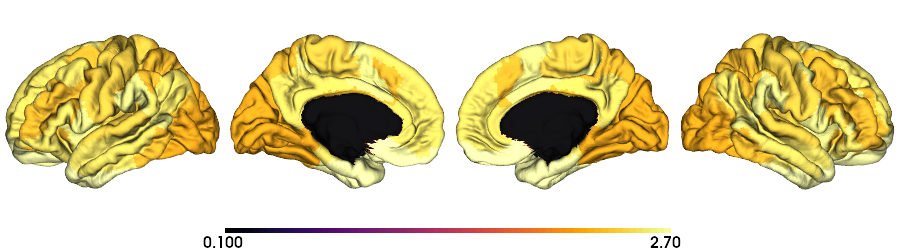

In [91]:
# plot mean CT per parcel on surface
plot_array = get_mean_CT_per_parcel(labels, PD_surf)
cmap = "inferno"
plot_hemispheres(pial_lh, pial_rh, array_name=plot_array, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap=cmap, transparent_bg=True, color_bar='bottom') #color_range=(1.5, 4),

### Difference between CTRL and PD

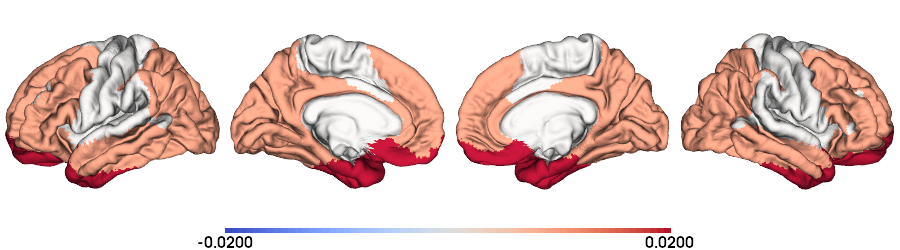

In [92]:
# plot mean CT per parcel on surface
plot_thresh = 0.05
diff_surf = surf_dict["CTRL"] - surf_dict["PD"]
diff_surf[(diff_surf < plot_thresh) & (diff_surf > -plot_thresh)] = 0

plot_array = get_mean_CT_per_parcel(labels, diff_surf, round_decimals=2)
color_range = (-max(abs(plot_array)), max(abs(plot_array)))
cmap = "coolwarm"
plot_hemispheres(pial_lh, pial_rh, array_name=plot_array, size=(900, 250), zoom=1.25, embed_nb=True, interactive=False, share='both',
                 nan_color=(0, 0, 0, 1), cmap=cmap, transparent_bg=True, color_bar='bottom',color_range=color_range)